In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold  # 데이터를 group 별로 나누고 각 활동(stratified) 비율은 유지 
from sklearn.utils.class_weight import compute_class_weight  # 데이터 불균형할 때 적은 class에 더 큰 weight 제공 
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import random
import os
DATA_PATH = 'C://Users/park9/HAR/MHEALTH/MHEALTHDATASET'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
def seed_everything(seed):
    """
    모든 random seed를 고정하는 함수
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42 
seed_everything(SEED)

print(f"Random seed set to {SEED}")

Random seed set to 42


In [3]:
N_FEATURES = 23 
N_CLASSES = 12
EPOCHS = 20
LR = 0.001
BATCH_SIZE = 64
WINDOW_SIZE = 50 # MHEALTH 데이터는 샘플링 주파수가 50Hz이므로, 1초=50
STEP_SIZE = 25 
HYPER_PARAMS = {'epochs': EPOCHS, 'lr': LR}

In [4]:
def load_mhealth_data(directory_path):

    # MHEALTH 데이터셋의 24개 컬럼 이름 정의
    column_names = [
        'chest_acc_X', 'chest_acc_Y', 'chest_acc_Z',
        'chest_ecg_1', 'chest_ecg_2',
        'chest_gyro_X', 'chest_gyro_Y', 'chest_gyro_Z',
        'chest_mag_X', 'chest_mag_Y', 'chest_mag_Z',
        'arm_acc_X', 'arm_acc_Y', 'arm_acc_Z',
        'arm_gyro_X', 'arm_gyro_Y', 'arm_gyro_Z',
        'ankle_acc_X', 'ankle_acc_Y', 'ankle_acc_Z',
        'ankle_gyro_X', 'ankle_gyro_Y', 'ankle_gyro_Z',
        'Label'
    ]

    # 활동 라벨 매핑 (키 값을 1~12 -> 0~11로 수정)
    activity_mapping = {
        0: 'Standing', 1: 'Sitting', 2: 'Lying', 3: 'Walking', 
        4: 'Climbing_Stairs', 5: 'Waist_Bends', 6: 'Frontal elevation of arms',
        7: 'Knees bending', 8: 'Cycling', 9: 'Jogging', 
        10: 'Running', 11: 'Jumping'
    }

    all_dfs = [] # 각 사용자 데이터를 저장할 빈 리스트
    
    # 지정된 디렉토리의 모든 파일을 순회
    for filename in os.listdir(directory_path):
        if filename.endswith('.log'):
            file_path = os.path.join(directory_path, filename)
            
            # 데이터를 공백 기준으로 읽어오기
            df_subject = pd.read_csv(file_path, header=None, sep=r'\s+', names=column_names)
            
            # 사용자 ID 추출하여 'User' 컬럼 추가 (예: 'mHealth_subject1.log' -> 1)
            user_id = int(filename.replace('mHealth_subject', '').replace('.log', ''))
            df_subject['User'] = user_id
            
            all_dfs.append(df_subject)
    
    # 모든 사용자의 데이터프레임을 하나로 합치기
    df_raw = pd.concat(all_dfs, ignore_index=True)
    
    # 'Null' 활동(라벨 0) 제거
    df_raw = df_raw[df_raw['Label'] != 0].copy()

    # Label을 0부터 시작하게 만들기
    df_raw['Label'] = df_raw['Label'] - 1

    # 숫자 라벨을 활동 이름으로 생성
    df_raw['Activity'] = df_raw['Label'].map(activity_mapping)
    
    print(f"Total shape: {df_raw.shape}")
    
    return df_raw

In [5]:
def select_and_preprocess_data(df):
    
    feature_columns = [
        'chest_acc_X', 'chest_acc_Y', 'chest_acc_Z',
        'chest_ecg_1', 'chest_ecg_2',
        'chest_gyro_X', 'chest_gyro_Y', 'chest_gyro_Z',
        'chest_mag_X', 'chest_mag_Y', 'chest_mag_Z',
        'arm_acc_X', 'arm_acc_Y', 'arm_acc_Z',
        'arm_gyro_X', 'arm_gyro_Y', 'arm_gyro_Z',
        'ankle_acc_X', 'ankle_acc_Y', 'ankle_acc_Z',
        'ankle_gyro_X', 'ankle_gyro_Y', 'ankle_gyro_Z'
    ]

    # 사용할 col만 모아서 df 생성 -> ver_2
    df_processed = df[['User', 'Activity', 'Label'] + feature_columns].copy()

    # 'Label' 컬럼을 'Activity_Encoded'로 이름만 변경 (일반화)
    df_processed.rename(columns={'Label': 'Activity_Encoded'}, inplace=True)

    # 데이터 스케일링
    scaler = StandardScaler()
    df_processed[feature_columns] = scaler.fit_transform(df_processed[feature_columns])

    print('전처리 완료')

    return df_processed, scaler

In [6]:
def subject_wise_split(df_processed, n_test_users=2):
    
    df = df_processed.copy()

    users = df['User'].unique()

    if n_test_users >= len(users):
        raise ValueError("테스트 사용자 수가 전체 사용자 수와 같거나 많을 수 없습니다.")
    
    np.random.shuffle(users)
    test_users = users[:n_test_users]
    train_val_users = users[n_test_users:]

    df_train_val = df[df['User'].isin(train_val_users)].copy()
    df_test = df[df['User'].isin(test_users)].copy()

    print(f"Train/Val set: {df_train_val.shape}, Users: {sorted(df_train_val['User'].unique())}")
    print(f"Test set: {df_test.shape},     Users: {sorted(df_test['User'].unique())}")

    return df_train_val, df_test

In [7]:
def create_windows(df, window_size, step_size):

    feature_columns = [
        'chest_acc_X', 'chest_acc_Y', 'chest_acc_Z',
        'chest_ecg_1', 'chest_ecg_2',
        'chest_gyro_X', 'chest_gyro_Y', 'chest_gyro_Z',
        'chest_mag_X', 'chest_mag_Y', 'chest_mag_Z',
        'arm_acc_X', 'arm_acc_Y', 'arm_acc_Z',
        'arm_gyro_X', 'arm_gyro_Y', 'arm_gyro_Z',
        'ankle_acc_X', 'ankle_acc_Y', 'ankle_acc_Z',
        'ankle_gyro_X', 'ankle_gyro_Y', 'ankle_gyro_Z'
    ]

    X, y = [], []
    for user_id in df['User'].unique():
        user_data = df[df['User'] == user_id]
        
        feature_data = user_data[feature_columns].values
        activity_labels = user_data['Activity_Encoded'].values

        for i in range(0, len(feature_data) - window_size + 1, step_size):
            window = feature_data[i: i + window_size]
            X.append(window)
            
            # 윈도우 내에서 가장 빈도가 높은 라벨을 해당 윈도우의 라벨로 지정
            window_labels = activity_labels[i: i + window_size]
            modal_label = np.bincount(window_labels).argmax()
            y.append(modal_label)
            
    return np.array(X), np.array(y)

In [8]:
class HAR_Dataset(Dataset):

    def __init__(self, X_data, y_data):
        X_data_reshaped = X_data.transpose(0, 2, 1)
        self.X_data = torch.tensor(X_data_reshaped, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.long)

    def __len__(self):
        return len(self.X_data)
    
    def __getitem__(self, idx):
        return self.X_data[idx], self.y_data[idx]

In [9]:
class CNN_LSTM(nn.Module):
    def __init__(self, n_features=N_FEATURES, hidden_size=512, num_layers=1, n_classes=N_CLASSES):
        super().__init__()

        self.cnn_extractor = nn.Sequential(
            nn.Conv1d(n_features, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )

        self.lstm = nn.LSTM(
            input_size=512,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False
        )

        self.dropout = nn.Dropout(0.6)
        self.classifier = nn.Linear(hidden_size, n_classes)

    def forward(self, x):
        x = self.cnn_extractor(x)
        x = x.permute(0, 2, 1)
        # h0, c0 생략
        _, (hn, _) = self.lstm(x)
        out = hn[-1]
        out = self.dropout(out)
        out = self.classifier(out)
        return out

In [10]:
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5, stride=1):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )
        
    def forward(self, x):
        residual = self.shortcut(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += residual
        out = self.relu(out)

        return out
    
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, seq_output):
        energy = torch.tanh(self.attn(seq_output))
        attn_scores = torch.einsum('bij,j->bi', energy, self.v)
        attention_weights = self.softmax(attn_scores)
        context_vector = torch.einsum('bi,bij->bj', attention_weights, seq_output)
        return context_vector, attention_weights
    
class ResNet_Attention(nn.Module):
    def __init__(self, n_features=N_FEATURES, n_classes=N_CLASSES):
        super().__init__()

        self.initial_conv = nn.Conv1d(n_features, 64, kernel_size=7, stride=2, padding=3)
        self.initial_bn = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = ResidualBlock1D(64, 64)
        self.layer2 = ResidualBlock1D(64, 128, stride=2) # stride=2로 시퀀스 길이를 줄임
        self.layer3 = ResidualBlock1D(128, 256, stride=2)

        self.attention = Attention(256)

        self.classifier = nn.Linear(256, n_classes)

    def forward(self, x):
        # 1. 초기 Conv + Pooling
        # Input shape: (B, 3, 80)
        x = self.maxpool(self.relu(self.initial_bn(self.initial_conv(x))))
        
        # 2. ResNet Blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x) # shape: (B, 256, Seq_len_reduced)
        
        # 3. Attention을 위한 차원 변경 (채널을 마지막 차원으로)
        x = x.permute(0, 2, 1) # shape: (B, Seq_len_reduced, 256)
        
        # 4. Attention 적용
        context_vector, _ = self.attention(x) # shape: (B, 256)
        
        # 5. 최종 분류
        output = self.classifier(context_vector)
        return output


In [11]:
def train_model(model, train_loader, val_loader, epochs, lr, criterion, device):

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-5)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train / total_train
        val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, device)
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
    return model, history

def evaluate_model(model, data_loader, criterion, device):

    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = correct / total
    
    return avg_loss, accuracy, all_preds, all_labels

def predict_ensemble(models, data_loader, device):

    all_probabilities = []  # 모든 모델의 예측 확률 저장 
    all_labels = []

    with torch.no_grad():
        for model in models:
            model.eval()
            model_probabilities = []

            # 첫 번째 루프에서만 실제 라벨을 가져옴 (모든 루프에서 동일하므로)
            if not all_labels:
                is_first_loop = True
            else:
                is_first_loop = False

            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                outputs  = model(inputs)

                probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
                model_probabilities.extend(probabilities)

                if is_first_loop:
                    all_labels.extend(labels.numpy())

            all_probabilities.append(model_probabilities)
    
    # 모델들의 예측 확률을 평균냄
    # (n_models, n_samples, n_classes) -> (n_samples, n_classes)
    avg_probabilities = np.mean(all_probabilities, axis=0)

    # 평균 확률이 가장 높은 클래스를 최종 예측으로 선택
    final_predictions = np.argmax(avg_probabilities, axis=1)

    return final_predictions, np.array(all_labels)

In [12]:
def run_cv_on_train_val(df_train_val, ModelClass, hyper_params, n_splits=5):
    
    all_val_accs = []
    models_from_cv = []  # 학습된 각 CV 모델을 저장할 리스트

    y_tv, groups_tv = df_train_val['Activity_Encoded'].values, df_train_val['User'].values
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(np.arange(len(df_train_val)), y_tv, groups=groups_tv)):
        print(f"\n======== Starting CV Fold {fold+1}/{n_splits} ({ModelClass.__name__}) ========")
        df_train_fold, df_val_fold = df_train_val.iloc[train_idx], df_train_val.iloc[val_idx]

        X_train, y_train = create_windows(df_train_fold, WINDOW_SIZE, STEP_SIZE)
        X_val, y_val = create_windows(df_val_fold, WINDOW_SIZE, STEP_SIZE)
        
        train_dataset = HAR_Dataset(X_train, y_train)
        val_dataset = HAR_Dataset(X_val, y_val)
        
        train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        weighted_criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float32).to(DEVICE))
        
        model = ModelClass().to(DEVICE)

        trained_model, history = train_model(model, train_loader, val_loader, 
                                 epochs=hyper_params["epochs"], lr=hyper_params["lr"], 
                                 criterion=weighted_criterion, device=DEVICE)
        
        models_from_cv.append(trained_model)  # 학슨된 모델들 저장 
        
        final_val_acc = history['val_acc'][-1]
        all_val_accs.append(final_val_acc)
        print(f"Fold {fold+1} Final Validation Accuracy: {final_val_acc:.4f}")

    mean_acc, std_acc = np.mean(all_val_accs), np.std(all_val_accs)
    print(f"\n--- CV Result for {ModelClass.__name__}: 평균 Acc = {mean_acc:.4f} (+/- {std_acc:.4f}) ---")
    
    return models_from_cv

Total shape: (343195, 26)
전처리 완료
Train/Val set: (276173, 26), Users: [1, 2, 3, 4, 5, 6, 7, 9]
Test set: (67022, 26),     Users: [8, 10]

--- Starting 5-Fold CV to generate ensemble models for ResNet_Attention ---

======== Starting CV Fold 1/5 (ResNet_Attention) ========
Epoch 1/20 - Train Loss: 0.2981, Train Acc: 0.9019 | Val Loss: 0.7082, Val Acc: 0.8514
Epoch 2/20 - Train Loss: 0.0594, Train Acc: 0.9820 | Val Loss: 1.1012, Val Acc: 0.7318
Epoch 3/20 - Train Loss: 0.0485, Train Acc: 0.9844 | Val Loss: 0.9942, Val Acc: 0.8367
Epoch 4/20 - Train Loss: 0.0145, Train Acc: 0.9950 | Val Loss: 0.6517, Val Acc: 0.8557
Epoch 5/20 - Train Loss: 0.0598, Train Acc: 0.9835 | Val Loss: 1.3624, Val Acc: 0.8289
Epoch 6/20 - Train Loss: 0.0183, Train Acc: 0.9937 | Val Loss: 0.9648, Val Acc: 0.8299
Epoch 7/20 - Train Loss: 0.0221, Train Acc: 0.9934 | Val Loss: 0.8914, Val Acc: 0.8135
Epoch 8/20 - Train Loss: 0.0109, Train Acc: 0.9972 | Val Loss: 0.9906, Val Acc: 0.8357
Epoch 9/20 - Train Loss: 0.0130,

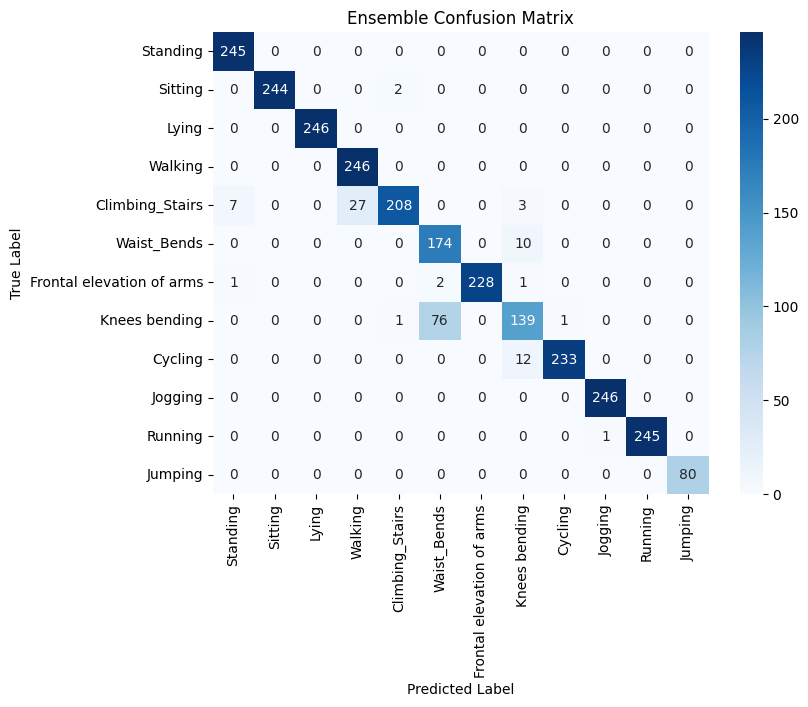

In [13]:
if __name__ == '__main__':
    # 데이터 준비
    df_mhealth_raw = load_mhealth_data(DATA_PATH)
    df_mhealth_processed, scaler = select_and_preprocess_data(df_mhealth_raw)

    df_train_val, df_test = subject_wise_split(df_mhealth_processed, n_test_users=2)

    # CV를 실행하여 앙상블할 모델 5개 얻기
    print(f"\n--- Starting 5-Fold CV to generate ensemble models for {ResNet_Attention.__name__} ---")
    
    # 5개의 학습된 모델을 얻기
    cv_models = run_cv_on_train_val(df_train_val, ResNet_Attention, HYPER_PARAMS)
    
    # 앙상블 모델로 Test Set 예측
    print("\n--- Predicting on Test Set using Ensemble Model ---")
    
    # Test Set을 위한 데이터로더 생성
    X_test, y_test = create_windows(df_test, WINDOW_SIZE, STEP_SIZE)
    test_dataset = HAR_Dataset(X_test, y_test)
    final_test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 앙상블 예측 함수 호출
    y_pred, y_true = predict_ensemble(cv_models, final_test_loader, DEVICE)
    
    # 최종 결과 출력 
    class_names = df_mhealth_processed.sort_values('Activity_Encoded')['Activity'].unique()
    print(f"\n================ Final Test Set Evaluation: Ensemble of {len(cv_models)} {ResNet_Attention.__name__} models ================")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Ensemble Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()